In [1]:
import numpy as np
import pandas as pd
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
%matplotlib inline

from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from myfun.try_gpu import *
from myfun.setup_seed import *
from myfun.create_dataset import *
from myfun.evaluation import *
from model.mlp import MLP

np.set_printoptions(threshold=np.inf)

In [2]:
data = pd.read_csv('dataset/B0005.csv')
ts = data['Capacity'].tolist()
Cy = data['Cycles'].tolist()

In [3]:
def train(hidden_size=[32, 16], look_back=16, lr=0.001, EPOCH=1000, seed=0, train_size=15):
    dataX, dataY = create_dataset(ts, look_back)

    test_size = len(dataX) - train_size
    train_x = torch.from_numpy(dataX[:train_size])
    train_y = torch.from_numpy(dataY[:train_size])
    test_x = torch.from_numpy(dataX[train_size:])
    test_y = torch.from_numpy(dataY[train_size:])
    print(train_x.shape)

    setup_seed(seed)
    model = MLP(input_size=look_back, hidden_dim=hidden_size)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)
    criterion = nn.MSELoss()

    score_list = []
    t_x = test_x.clone()
    loss_list = [0]
    mae, mse, rmse, r2 = 1, 1, 1, 1
    score_, score = 1,1
    for epoch in range(EPOCH):
        model.train()
        train_x = train_x.to(torch.float32).to(device)
        train_y = train_y.to(torch.float32).reshape(train_size, -1).to(device)
    
        out = model(train_x)
        loss = criterion(out, train_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch + 1)%100 == 0:     #每100次重新预测一次
            model.eval()
            with torch.no_grad():
                t_x = test_x.clone()   
                t_x = t_x.to(torch.float32).to(device)
                pred_test = model(t_x) # 测试集的预测结果
                pred_test = pred_test.view(-1).cpu().detach().numpy()
            loss_list.append(loss)
            mae, mse, rmse, r2 = evaluation(test_y=test_y, pred_test=pred_test)

            print('epoch:{:<2d} | loss:{:<6.4f} | MAE:{:<6.4f} | MSE:{:<6.4f} | RMSE:{:<6.4f} | R2:{:<6.3f}'.format(epoch+1, loss, mae, mse, rmse, r2))
        
        score = [mae, mse, rmse, r2]
        # if (loss < 1e-3) and (score_[0] < score[0]) and (score_[2] < score[2]):
        #     break
        score_ = score.copy()
    score_list.append(score_)
    return score_list, pred_test

# 模型训练

## 30

In [4]:
hidden_size = [32, 16]
look_back=16
lr=0.001
EPOCH=200
seed=0
train_size=15

device = try_gpu(10)
print("train on:",try_gpu(10))
score_list, pred_test = train(hidden_size=hidden_size, look_back=look_back, 
                                lr=lr, EPOCH=EPOCH, seed=seed, train_size=train_size)

train on: cpu
torch.Size([15, 1, 16])
epoch:100 | loss:0.0004 | MAE:0.0588 | MSE:0.0038 | RMSE:0.0614 | R2:0.858 
epoch:200 | loss:0.0003 | MAE:0.0554 | MSE:0.0034 | RMSE:0.0580 | R2:0.874 


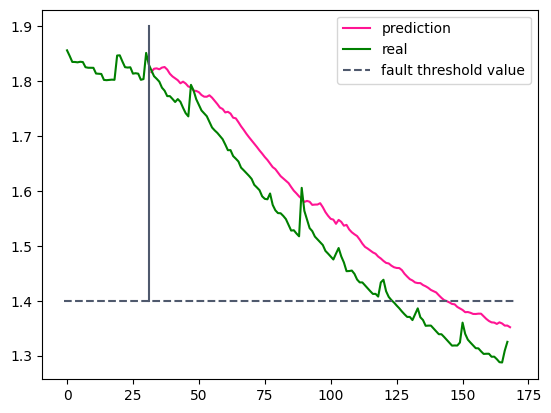

In [30]:
plt.plot(Cy[train_size+look_back:],pred_test, 'deeppink', label='prediction')
plt.plot(ts, 'green', label='real')
plt.plot([train_size+look_back,train_size+look_back],[1.4, 1.9], c='#4f596d', lw=1.5)
plt.plot([-1,170],[1.4, 1.4], c='#4f596d', lw=1.5, ls='--', label = 'fault threshold value')
plt.legend(loc='best')

In [31]:
txt = pred_test.tolist()
txt

[1.8168911933898926,
 1.8229912519454956,
 1.8236415386199951,
 1.8219590187072754,
 1.8250436782836914,
 1.8260829448699951,
 1.8214530944824219,
 1.8137853145599365,
 1.8089070320129395,
 1.8055307865142822,
 1.8020472526550293,
 1.796454668045044,
 1.7994117736816406,
 1.79597008228302,
 1.790497899055481,
 1.7893249988555908,
 1.782961130142212,
 1.7824718952178955,
 1.7801904678344727,
 1.775022029876709,
 1.7720422744750977,
 1.771918773651123,
 1.7745355367660522,
 1.770226240158081,
 1.7642996311187744,
 1.758591890335083,
 1.7520551681518555,
 1.7496263980865479,
 1.7433058023452759,
 1.7444548606872559,
 1.74124276638031,
 1.7336745262145996,
 1.7325563430786133,
 1.7255761623382568,
 1.7180593013763428,
 1.7115848064422607,
 1.7045279741287231,
 1.6981942653656006,
 1.6923028230667114,
 1.6864042282104492,
 1.680356502532959,
 1.673998475074768,
 1.6682333946228027,
 1.6619778871536255,
 1.6566438674926758,
 1.6500333547592163,
 1.643598198890686,
 1.6399859189987183,
 1.633

## 60

In [38]:
hidden_size = [32, 16]
look_back=16
lr=0.001
EPOCH=6000
seed=0
train_size=45

device = try_gpu(10)
print("train on:",try_gpu(10))
score_list, pred_test = train(hidden_size=hidden_size, look_back=look_back, 
                                lr=lr, EPOCH=EPOCH, seed=seed, train_size=train_size)

train on: cpu
torch.Size([45, 1, 16])
epoch:100 | loss:0.0006 | MAE:0.0474 | MSE:0.0024 | RMSE:0.0486 | R2:0.812 
epoch:200 | loss:0.0006 | MAE:0.0446 | MSE:0.0021 | RMSE:0.0459 | R2:0.833 
epoch:300 | loss:0.0006 | MAE:0.0445 | MSE:0.0021 | RMSE:0.0458 | R2:0.833 
epoch:400 | loss:0.0006 | MAE:0.0445 | MSE:0.0021 | RMSE:0.0457 | R2:0.834 
epoch:500 | loss:0.0006 | MAE:0.0444 | MSE:0.0021 | RMSE:0.0457 | R2:0.835 
epoch:600 | loss:0.0006 | MAE:0.0443 | MSE:0.0021 | RMSE:0.0456 | R2:0.835 
epoch:700 | loss:0.0006 | MAE:0.0442 | MSE:0.0021 | RMSE:0.0455 | R2:0.836 
epoch:800 | loss:0.0006 | MAE:0.0440 | MSE:0.0021 | RMSE:0.0453 | R2:0.837 
epoch:900 | loss:0.0006 | MAE:0.0439 | MSE:0.0020 | RMSE:0.0452 | R2:0.838 
epoch:1000 | loss:0.0006 | MAE:0.0438 | MSE:0.0020 | RMSE:0.0451 | R2:0.839 
epoch:1100 | loss:0.0006 | MAE:0.0436 | MSE:0.0020 | RMSE:0.0449 | R2:0.840 
epoch:1200 | loss:0.0006 | MAE:0.0435 | MSE:0.0020 | RMSE:0.0448 | R2:0.841 
epoch:1300 | loss:0.0006 | MAE:0.0433 | MSE:0.0

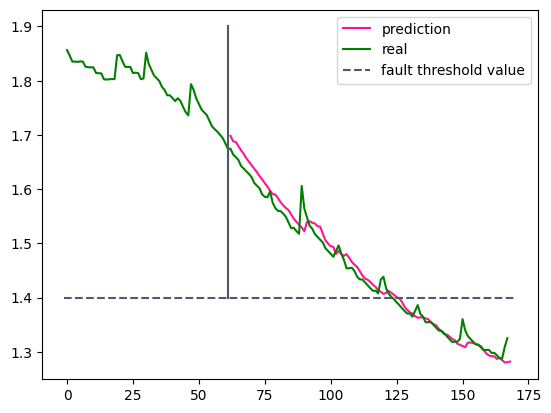

In [39]:
plt.plot(Cy[train_size+look_back:],pred_test, 'deeppink', label='prediction')
plt.plot(ts, 'green', label='real')
plt.plot([train_size+look_back,train_size+look_back],[1.4, 1.9], c='#4f596d', lw=1.5)
plt.plot([-1,170],[1.4, 1.4], c='#4f596d', lw=1.5, ls='--', label = 'fault threshold value')
plt.legend(loc='best')

In [40]:
txt = pred_test.tolist()
txt

[1.6983486413955688,
 1.6881680488586426,
 1.6869350671768188,
 1.6793042421340942,
 1.6715987920761108,
 1.6649755239486694,
 1.6568821668624878,
 1.6504333019256592,
 1.6441221237182617,
 1.6378268003463745,
 1.6314915418624878,
 1.623976707458496,
 1.617831826210022,
 1.6110312938690186,
 1.6046894788742065,
 1.597089409828186,
 1.5906747579574585,
 1.5900324583053589,
 1.583229899406433,
 1.5757726430892944,
 1.5701903104782104,
 1.5652025938034058,
 1.5611823797225952,
 1.5531364679336548,
 1.5454211235046387,
 1.5396336317062378,
 1.5343165397644043,
 1.529309630393982,
 1.5220757722854614,
 1.5393645763397217,
 1.540795922279358,
 1.5380198955535889,
 1.536595106124878,
 1.5315889120101929,
 1.5306956768035889,
 1.5178749561309814,
 1.5055804252624512,
 1.4992694854736328,
 1.494801640510559,
 1.4935141801834106,
 1.480346918106079,
 1.4862380027770996,
 1.4802436828613281,
 1.4771199226379395,
 1.4801034927368164,
 1.473438024520874,
 1.4657355546951294,
 1.4605728387832642,
 1

## 90

In [41]:
hidden_size = [32, 16]
look_back=16
lr=0.001
EPOCH=3400
seed=0
train_size=75

device = try_gpu(10)
print("train on:",try_gpu(10))
score_list, pred_test = train(hidden_size=hidden_size, look_back=look_back, 
                                lr=lr, EPOCH=EPOCH, seed=seed, train_size=train_size)

train on: cuda:0
torch.Size([75, 1, 16])
epoch:100 | loss:0.0010 | MAE:0.0335 | MSE:0.0012 | RMSE:0.0351 | R2:0.753 
epoch:200 | loss:0.0009 | MAE:0.0311 | MSE:0.0011 | RMSE:0.0328 | R2:0.785 
epoch:300 | loss:0.0009 | MAE:0.0309 | MSE:0.0011 | RMSE:0.0326 | R2:0.788 
epoch:400 | loss:0.0009 | MAE:0.0306 | MSE:0.0010 | RMSE:0.0323 | R2:0.792 
epoch:500 | loss:0.0009 | MAE:0.0303 | MSE:0.0010 | RMSE:0.0319 | R2:0.797 
epoch:600 | loss:0.0009 | MAE:0.0299 | MSE:0.0010 | RMSE:0.0315 | R2:0.802 
epoch:700 | loss:0.0009 | MAE:0.0295 | MSE:0.0010 | RMSE:0.0311 | R2:0.807 
epoch:800 | loss:0.0009 | MAE:0.0290 | MSE:0.0009 | RMSE:0.0306 | R2:0.813 
epoch:900 | loss:0.0009 | MAE:0.0285 | MSE:0.0009 | RMSE:0.0301 | R2:0.819 
epoch:1000 | loss:0.0009 | MAE:0.0280 | MSE:0.0009 | RMSE:0.0296 | R2:0.826 
epoch:1100 | loss:0.0009 | MAE:0.0275 | MSE:0.0008 | RMSE:0.0290 | R2:0.832 
epoch:1200 | loss:0.0009 | MAE:0.0269 | MSE:0.0008 | RMSE:0.0283 | R2:0.840 
epoch:1300 | loss:0.0008 | MAE:0.0262 | MSE:

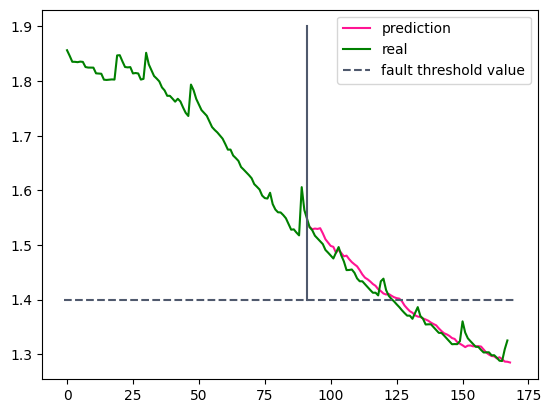

In [33]:
plt.plot(Cy[train_size+look_back:],pred_test, 'deeppink', label='prediction')
plt.plot(ts, 'green', label='real')
plt.plot([train_size+look_back,train_size+look_back],[1.4, 1.9], c='#4f596d', lw=1.5)
plt.plot([-1,170],[1.4, 1.4], c='#4f596d', lw=1.5, ls='--', label = 'fault threshold value')
plt.legend(loc='best')

In [34]:
txt = pred_test.tolist()
txt

[1.5330740213394165,
 1.5286540985107422,
 1.5299723148345947,
 1.529303789138794,
 1.5306390523910522,
 1.5212550163269043,
 1.5104050636291504,
 1.5042452812194824,
 1.4981505870819092,
 1.4965205192565918,
 1.4857113361358643,
 1.4915269613265991,
 1.4852546453475952,
 1.4791607856750488,
 1.480360746383667,
 1.4738925695419312,
 1.4685554504394531,
 1.4644756317138672,
 1.4607901573181152,
 1.453794002532959,
 1.4459645748138428,
 1.4400382041931152,
 1.436995267868042,
 1.4330337047576904,
 1.4283983707427979,
 1.4251009225845337,
 1.4189369678497314,
 1.415472149848938,
 1.411055326461792,
 1.4092252254486084,
 1.410271406173706,
 1.4071002006530762,
 1.4042953252792358,
 1.4025620222091675,
 1.401679277420044,
 1.3969712257385254,
 1.389057993888855,
 1.3835700750350952,
 1.3786406517028809,
 1.3758257627487183,
 1.3710548877716064,
 1.3688440322875977,
 1.368163824081421,
 1.3652963638305664,
 1.3634711503982544,
 1.3612059354782104,
 1.3577592372894287,
 1.3551466464996338,
 1